In [ ]:
# # DDPM (Diffusion) training notebook — Clean, RGB-ready

# **Purpose:** A compact, working template to train a 3-channel (RGB) DDPM / UNet model on microstructure (IPF) images.

# **Notes:**
# - This notebook expects your data to be organized as `root/ClassName/Images/*.png` etc.
# - Uses `diffusers` for UNet and scheduler. Make sure `diffusers>=0.28.0` is installed.
# - Model configured for `in_channels=3` and `out_channels=3` (RGB).

# Run each cell sequentially. If a cell requires installing packages, run it and restart the kernel before continuing.


In [1]:
!pip install -U diffusers==0.34.0 accelerate transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 10.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 103.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3

In [2]:
# 1) Environment checks and optional installs
import sys, platform
print('Python:', sys.version.splitlines()[0])
print('Platform:', platform.platform())

# Check key packages (do not auto-install here; uncomment to install if needed)
try:
    import torch, torchvision, diffusers
    print('torch:', torch.__version__)
    print('torch.cuda.is_available():', torch.cuda.is_available())
    print('diffusers:', diffusers.__version__)
except Exception as e:
    print('One or more packages are missing or failed to import:', e)
    print('\nIf you need to install, run:')
    print('!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121  # or cpu wheels')
    print('!pip install -U diffusers accelerate transformers')

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.6.56+-x86_64-with-glibc2.35
torch: 2.6.0+cu124
torch.cuda.is_available(): True
diffusers: 0.34.0


In [3]:
# 2) Imports, device, helper functions
import os, math, random, time
from pathlib import Path
from typing import Tuple

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# diffusers components (UNet2DModel, scheduler)
from diffusers import UNet2DModel, DDPMScheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

2025-11-14 21:42:04.423257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763156524.605517      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763156524.656241      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [4]:
# 3) Dataset (RGB) - robust and simple
class MicrostructureDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, exts=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        if exts is None:
            exts = {'.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'}
        for idx, cls in enumerate(self.class_names):
            img_folder = self.root_dir / cls / 'Images'
            if not img_folder.exists():
                # fallback: look directly in the class folder
                img_folder = self.root_dir / cls
            for p in img_folder.iterdir() if img_folder.exists() else []:
                if p.suffix.lower() in exts:
                    self.image_paths.append(p)
                    self.labels.append(idx)
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        p = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(p).convert('RGB')   # Keep RGB!
        if self.transform:
            img = self.transform(img)
        return img, label

# Example transform for training (RGB normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),                # -> [0,1] float32, shape (C,H,W)
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # to [-1,1]
])

Found classes: ['Compression', 'Compression_Shear', 'Shear', 'Tension', 'Tension_Shear']
Num images: 982


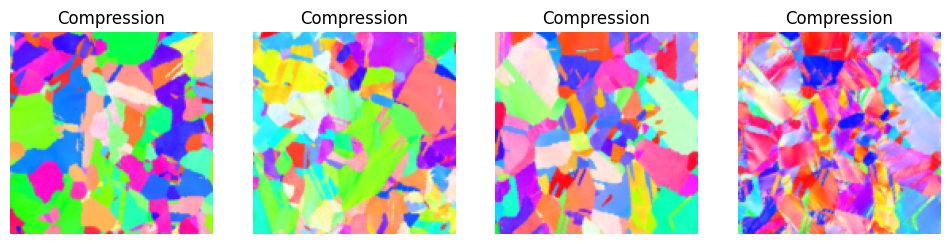

In [5]:
# 4) Instantiate dataset & dataloader (update root_dir to your dataset path)
root_dir = '/kaggle/input/five-classes/Class'  # <<-- CHANGE to your local path
batch_size = 16

dataset = MicrostructureDataset(root_dir=root_dir, transform=transform)
print('Found classes:', dataset.class_names)
print('Num images:', len(dataset))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# Visual sanity check: show 4 images
import matplotlib.pyplot as plt
if len(dataset)>0:
    fig, axs = plt.subplots(1,4, figsize=(12,3))
    for i in range(4):
        img, lbl = dataset[i]
        # img is normalized to [-1,1]; bring back to [0,1] for plotting
        im = ((img.permute(1,2,0).numpy() * 0.5) + 0.5)
        axs[i].imshow(np.clip(im,0,1))
        axs[i].set_title(dataset.class_names[lbl])
        axs[i].axis('off')
    plt.show()

In [6]:
# 5) Create a UNet2DModel configured for RGB images and (optional) class-conditioning
num_classes = len(dataset.class_names) if len(dataset.class_names)>0 else 2
print('num_classes set to', num_classes)

unet = UNet2DModel(
    sample_size=128,         # the target image size
    in_channels=3,           # RGB in
    out_channels=3,          # RGB out (predicting RGB noise)
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    # Enable class conditioning only if you want conditional generation (optional)
    add_attention=True,
    class_embed_type='timestep',  # keep default; we'll use a simple class embedding if needed
    num_class_embeds=num_classes
)

unet.to(device)
print('UNet conv_in weight shape:', unet.conv_in.weight.shape)

num_classes set to 5
UNet conv_in weight shape: torch.Size([64, 3, 3, 3])


In [7]:
# 6) Scheduler, optimizer, helpers
from torch.optim import AdamW

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = AdamW(unet.parameters(), lr=2e-4)

# helper: convert images [-1,1] -> noise + timestep + denoising target
def get_noise_targets(images, device):
    # images: tensor in [-1,1], shape [B,3,H,W]
    batch_size = images.shape[0]
    timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch_size,), device=device).long()
    noise = torch.randn_like(images)
    noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
    return noisy_images, noise, timesteps

# EMA (optional light implementation)
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {n: p.clone().detach() for n,p in model.named_parameters() if p.requires_grad}
    def update(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = (1.0 - self.decay) * p.detach() + self.decay * self.shadow[n]
    def store(self, model): self._backup = {n:p.clone() for n,p in model.named_parameters() if p.requires_grad}
    def restore(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                p.data.copy_(self._backup[n])
ema = EMA(unet)

In [ ]:
# 7) Training loop (template). This is intentionally compact.
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

epochs = 100  # set higher for real training
log_every = 10
step = 0

unet.train()
for epoch in range(epochs):
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
    for imgs, labels in pbar:
        imgs = imgs.to(device)  # imgs in [-1,1]
        # 1. create noisy images and targets
        noisy_imgs, noise, timesteps = get_noise_targets(imgs, device)
        optimizer.zero_grad()
        with torch.autocast('cuda'):
            # Predict noise
            # If model is class-conditional, pass 'class_labels' to forward() (diffusers UNet API)
            outputs = unet(noisy_imgs, timesteps, class_labels=labels.to(device))
            # diffusers UNet returns a ModelOutput - predicted noise under `.sample` or as tensor
            # Some versions return a dict-like object; handle both:
            noise_pred = outputs.sample if hasattr(outputs, 'sample') else outputs
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # EMA update
        ema.update(unet)
        if step % log_every == 0:
            pbar.set_postfix({'loss': loss.item()})
        step += 1

cpu_sd = {k: v.cpu() for k, v in unet.state_dict().items()}
torch.save(cpu_sd, "/kaggle/working/unet_microgen_rgb_ema_applied.pt", _use_new_zipfile_serialization=False)
    

/tmp/ipykernel_39/3907447072.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/100:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/62 [00:00<?, ?it/s]

In [15]:
@torch.no_grad()
def sample_batch(model, scheduler, batch_size=16, class_id=None, device='cuda'):
    """
    Generates a batch of images using the diffusion model.
    batch_size = number of images (16 for a 4×4 grid)
    class_id = None for unconditional models, or integer for conditional models
    """
    model.eval()
    x = torch.randn(batch_size, 3, 128, 128, device=device)

    # Optional class conditioning
    if class_id is not None:
        class_labels = torch.tensor([class_id] * batch_size, device=device)
    else:
        class_labels = None

    for t in tqdm(reversed(range(scheduler.num_train_timesteps)), desc="Sampling"):
        t_batch = torch.tensor([t] * batch_size, device=device)

        with torch.autocast("cuda"):
            out = model(x, t_batch, class_labels=class_labels)
            noise_pred = out.sample if hasattr(out, "sample") else out

        x = scheduler.step(noise_pred, t, x).prev_sample

    # Convert to numpy [0,1]
    imgs = x.clamp(-1, 1)
    imgs = (imgs + 1) / 2
    imgs = imgs.permute(0, 2, 3, 1).cpu().numpy()

    return imgs


In [16]:
def plot_grid(imgs, rows=4, cols=4, size=3):
    """
    imgs: array of images (N, H, W, 3)
    rows, cols: grid size
    size: figure scaling
    """
    assert len(imgs) >= rows*cols, "Not enough images to fill the grid."

    fig, axes = plt.subplots(rows, cols, figsize=(cols*size, rows*size))

    idx = 0
    for i in range(rows):
        for j in range(cols):
            axes[i][j].imshow(imgs[idx])
            axes[i][j].axis("off")
            idx += 1

    plt.tight_layout()
    plt.show()


In [17]:
# 9) Utilities: save & load helpers
def save_checkpoint(model, optimizer, path):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)

def load_checkpoint(model, optimizer, path, map_location=None):
    ck = torch.load(path, map_location=map_location)
    model.load_state_dict(ck['model_state_dict'])
    if optimizer is not None and 'optimizer_state_dict' in ck:
        optimizer.load_state_dict(ck['optimizer_state_dict'])
    return model, optimizer

Sampling: 0it [00:00, ?it/s]

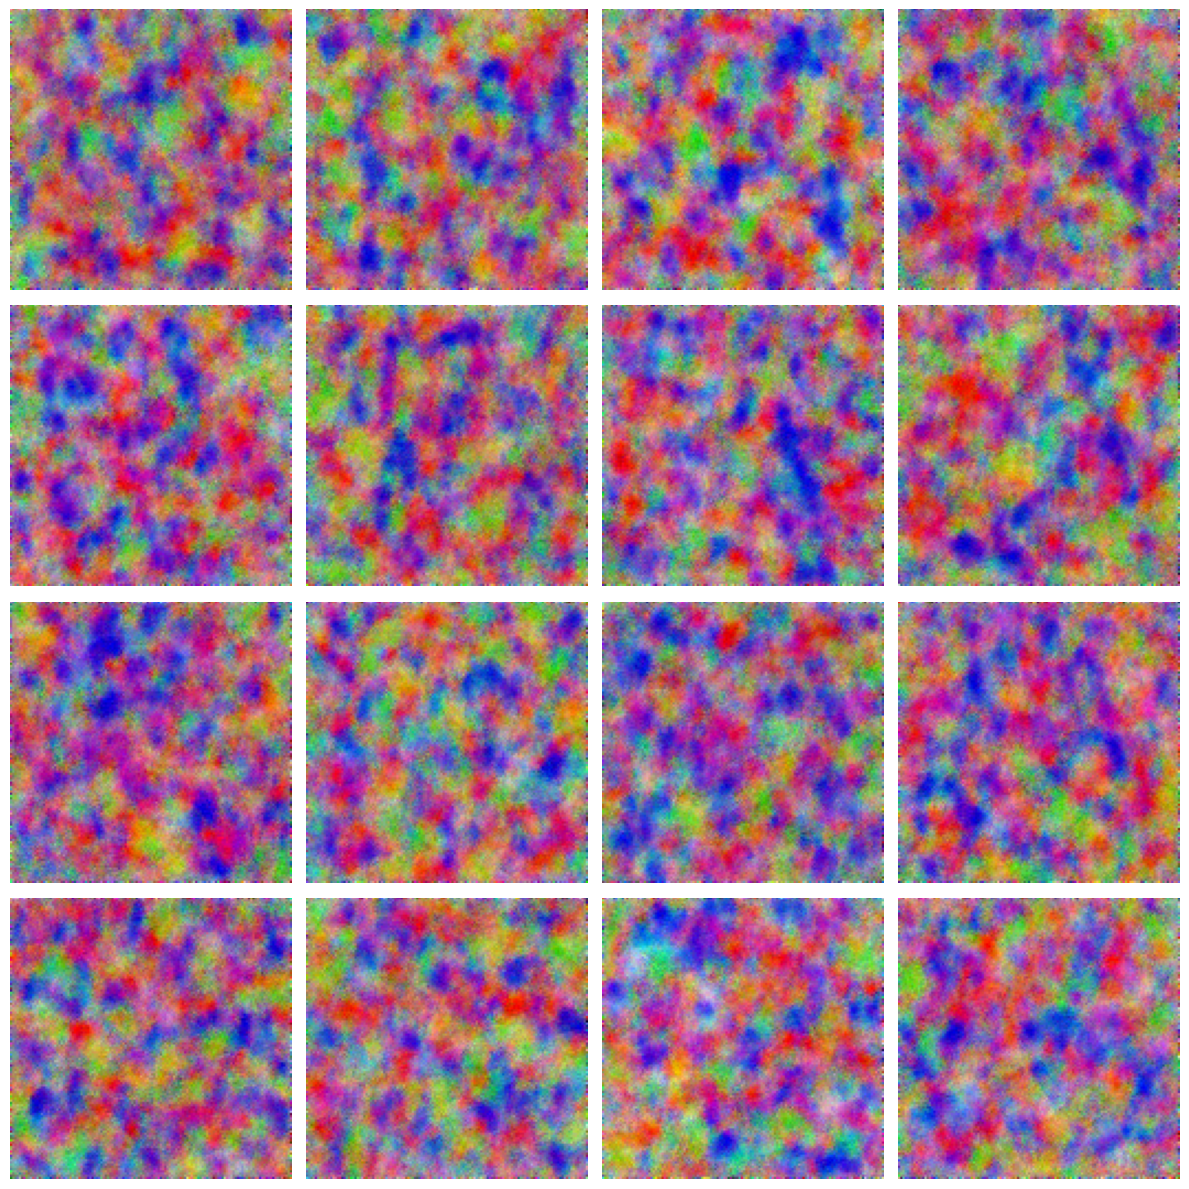

In [18]:
imgs = sample_batch(unet, noise_scheduler, batch_size=16, class_id=0)
plot_grid(imgs, rows=4, cols=4)